In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [2]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [3]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


<Axes: ylabel='Count'>

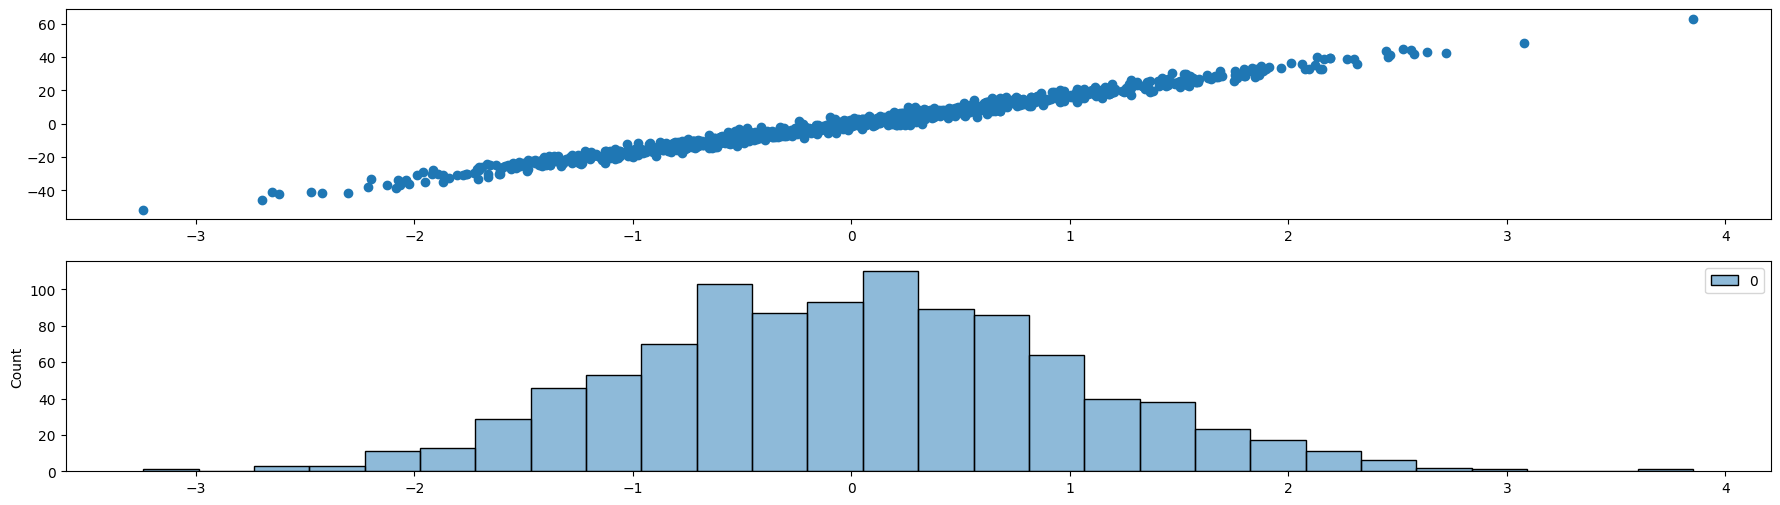

In [4]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1])

## Funciones auxiliares para generar datos anómalos

In [5]:
def generate_nulls(df: pd.DataFrame,
                   cols: list = None,
                   percentage: float = 0.05) -> pd.DataFrame:
  """Con esta función vamos a poder generar nulos en ciertas columnas de nuestro
  dataset.
  """  
  cols = df.columns.tolist() if cols is None else cols
  seeds = np.random.randint(100, size = len(cols))
  
  nsamples = np.math.floor(len(df) * percentage)

  result = df.copy(deep = True)
  for i,col_name in enumerate(cols):
      np.random.seed(seeds[i])
      
      idx_to_remove = result[col_name].sample(n = nsamples).index
      result[col_name].iloc[idx_to_remove] = np.nan if result[col_name].dtype in [int,float] else None
  
  return result

def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     two_tailed: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión (puede ser bilateral o unilateral segun _two_tailed_)
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)

    lb = result[col_name].quantile(0.25) - 1 * iqr
    ub = result[col_name].quantile(0.75) + 1 * iqr

    if two_tailed:
      outs = result[col_name].loc[(result[col_name] < lb) | (result[col_name] > ub)]
    else:
      outs = result[col_name].loc[(result[col_name] > ub)]
    
    out_size = len(outs)
    if out_size < nsamples:
      nsamples = out_size

    idx_to_change = outs.sample(nsamples, replace = False).index
    
    if extreme_outlier:
      outlier_sign = [1 if np.random.random() < 0.9 else -1 for _ in range(nsamples)]
      
      result[col_name].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result[col_name].mean(),
                                                                          high = result[col_name].max()*5,
                                                                          size = nsamples)
                                                        )
      result['target'].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result['target'].mean(),
                                                                          high = result['target'].max()*2,
                                                                          size = nsamples)
                                                        )
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].loc[idx_to_change] = samples
  
  return result

In [6]:
df_outlier = generate_outliers(df,['feature_1'], percentage = 0.05, extreme_outlier = True, two_tailed= True)

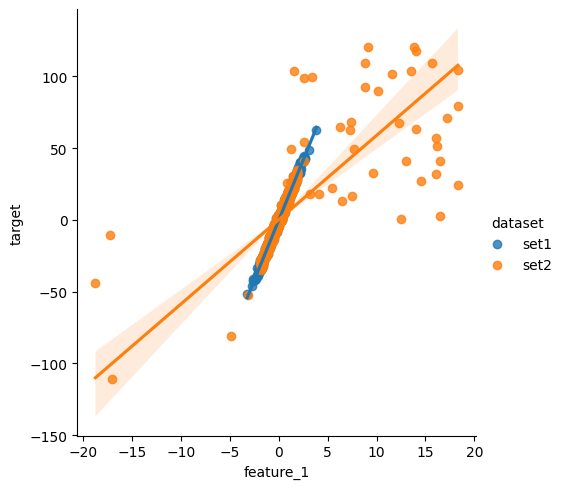

In [7]:
sns.lmplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [8]:
columnas_a_modificar = ['feature_1'] 
df_missing = generate_nulls(df,columnas_a_modificar, percentage = 0.01)

In [9]:
df_missing.isna().sum()

feature_1    10
target        0
dtype: int64

# Ejercicio 1

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

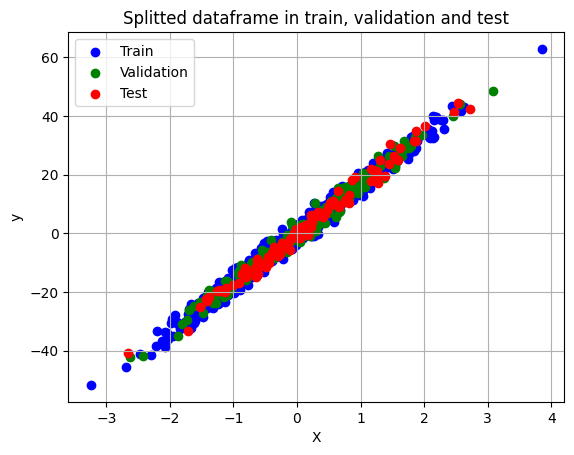

In [10]:
def split(df: pd.DataFrame, train_size: float, validation_size: float, test_size: float):
    i = 0
    i_initial = 0
    i_final = len(df.feature_1)

    X_train = np.array([])
    x_val = np.array([])
    X_test = np.array([])

    y_train = np.array([])
    y_val = np.array([])
    y_test = np.array([])


    # Calculo la cantidad de valores que hay para train, validation y test
    n_train = round((i_final-i_initial)*train_size)
    n_val = round((i_final-i_initial)*validation_size)
    n_test = round((i_final-i_initial)*test_size)    

    # Desordeno el array dentro del subarray y agarro en orden
    arr = np.arange(i_initial, i_final, 1)
    np.random.shuffle(arr)
    chosen_idx_train = arr[0:n_train]
    chosen_idx_validation = arr[n_train:n_train+n_val]
    chosen_idx_test = arr[n_train+n_val:n_train+n_val+n_test]

    for j in chosen_idx_train:
      X_train = np.append(X_train, df.feature_1[j])
      y_train = np.append(y_train, df.target[j])

    for j in chosen_idx_validation:
      x_val = np.append(x_val, df.feature_1[j])
      y_val = np.append(y_val, df.target[j])

    for j in chosen_idx_test:
      X_test = np.append(X_test, df.feature_1[j])
      y_test = np.append(y_test, df.target[j])
    
    return X_train, x_val, X_test, y_train, y_val, y_test


X_train, x_val, X_test, y_train, y_val, y_test = split(df, 0.7, 0.2, 0.1)

plt.scatter(X_train, y_train, c='b')
plt.scatter(x_val, y_val, c='g')
plt.scatter(X_test, y_test, c='r')
plt.title('Splitted dataframe in train, validation and test')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Train','Validation','Test'])
plt.grid()

# Ejercicio 2

Utilizando la funcion `generate_nulls`. Insertar en la columna de features un 5% de valores nulos. Con esto, generar una función que les permita rellenar estos valores con la mediana, y otro con la media.

Compare los __scores__ obtenidos en las regresiones cuando tiene el dataset completo, y con los dos métodos de imputación. ¿Cambian mucho?

In [11]:
df.feature_1.median()

0.025300612234888248

In [12]:
# def mean_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
def mean_imputer(df: pd.DataFrame) -> pd.DataFrame:
    # Calcular la media de cada columna
    media_por_columna = df.mean()
    
    # Rellenar los valores nulos de cada columna con su media
    df_rellenado = df.fillna(media_por_columna)
    
    return df_rellenado
    

In [13]:
# def median_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
def median_imputer(df: pd.DataFrame) -> pd.DataFrame:
    
    # Calcular la mediana de cada columna
    mediana_por_columna = df.median()
    
    # Rellenar los valores nulos de cada columna con su mediana
    df_rellenado = df.fillna(mediana_por_columna)
    
    return df_rellenado

In [14]:
columnas_a_modificar = ['feature_1'] 
df_nulls = generate_nulls(df,columnas_a_modificar, percentage = 0.05)

In [15]:
df_median = median_imputer(df_nulls)

df_mean = mean_imputer(df_nulls)

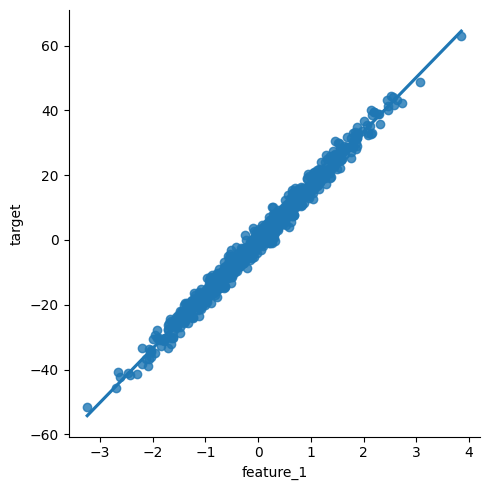

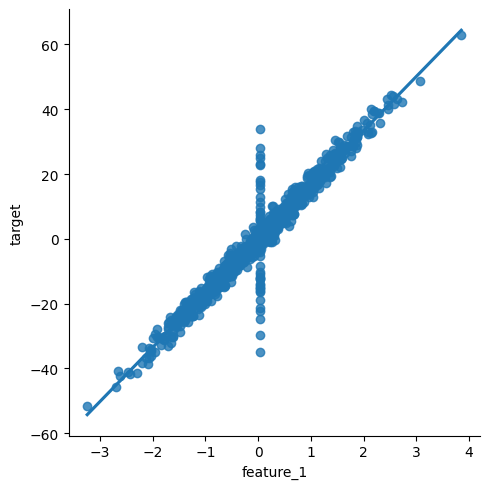

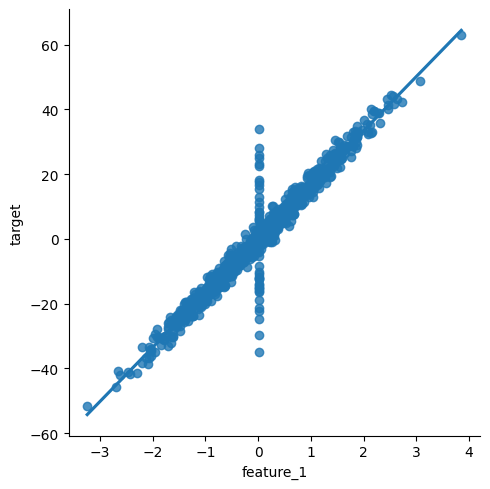

In [16]:
sns.lmplot(data = df_nulls, x = 'feature_1', y = 'target')
sns.lmplot(data = df_median, x = 'feature_1', y = 'target')
sns.lmplot(data = df_mean, x = 'feature_1', y = 'target')

# Ejercicio 3

Los resultados del ejercicio 1 ¿Cómo se ven afectados cuando empezamos a a tener muchos más valores imputados? Pruebe con distintos porcentajes.

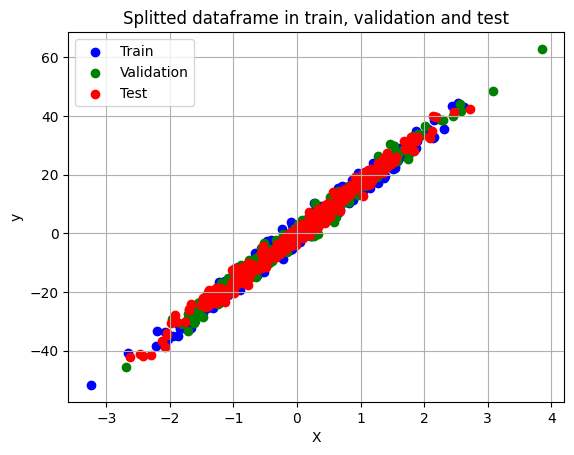

In [17]:
X_train, x_val, X_test, y_train, y_val, y_test = split(df, 0.4, 0.3, 0.3)

plt.scatter(X_train, y_train, c='b')
plt.scatter(x_val, y_val, c='g')
plt.scatter(X_test, y_test, c='r')
plt.title('Splitted dataframe in train, validation and test')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Train','Validation','Test'])
plt.grid()

# Ejercicio 4

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

In [18]:
df_outlier_e3 = generate_outliers(df,['feature_1'], percentage = 0.05, extreme_outlier = False, two_tailed= True)

# sns.lmplot(data = pd.concat([df.assign(dataset = 'set1'),
#                                  df_outlier_e3.assign(dataset = 'set2')]),
#                 x = 'feature_1',
#                 y = 'target',
#                 hue = 'dataset')

# df.target.shape, df.feature_1.shape
x = df.target.values
y = df.feature_1.values

x = x.reshape((1000,1))
y = y.reshape((1000,1))

lr = LinearRegression(fit_intercept=True)
lr.fit(x,y)
lr.score(x,y)

0.9855792900364626

In [19]:
# df_outlier_e3.feature_1.shape,df_outlier_e3.target.shape

x2 = df_outlier_e3.target.values
y2 = df_outlier_e3.feature_1.values

x2 = x2.reshape((1000,1))
y2 = y2.reshape((1000,1))

lr.fit(x2,y2)
lr.score(x2,y2)

0.5108556475589956

In [20]:
# Se observa que con un 5 % con extreme_utlet = False la regresion lineal vale la mitad.

# Ejercicio 5

Generar ahora valores extremos utilizando `extreme_outliers`. ¿Cómo afecta esto a la regresión? ¿Se observa algo interesante?


In [21]:
df_outlier_e4 = generate_outliers(df,['feature_1'], percentage = 0.05, extreme_outlier = True, two_tailed= True)

# df_outlier_e4.feature_1.shape,df_outlier_e4.target.shape

x3 = df_outlier_e4.target.values
y3 = df_outlier_e4.feature_1.values

x3 = x3.reshape((1000,1))
y3 = y3.reshape((1000,1))

lr.fit(x3,y3)
lr.score(x3,y3)

0.6439766148983959

# Ejercicio 6

utilizando el archivo CSV `clase3v2.csv`, vamos a cargarlo como dataframe y deberemos:
 - Generar splits de training/test
 - Limpiar/Imputar datos Nulos
 - Entrenar un modelo de regresión simple
 - Reportar $R^2$ en test.

In [22]:
data_happiness = pd.read_csv('clase3v2.csv', delimiter = ';')

data_happiness.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
1,13.505001,4.482330,NaN,0.770769,NaN,-3.706287,32.866898
2,-5.736774,-1.030994,NaN,0.907981,NaN,5.332656,-20.922094
3,-0.019325,1.909841,NaN,0.137427,NaN,3.400036,1.433380
4,6.079670,1.528345,NaN,0.746475,NaN,-11.486688,11.867943


In [23]:
data_happiness_outlier = generate_outliers(data_happiness,['feature_1'], percentage = 0.01, extreme_outlier = True, two_tailed= True)

In [24]:
columnas_a_modificar = ['feature_1'] 
data_happiness_missing = generate_nulls(data_happiness,columnas_a_modificar, percentage = 0.01)

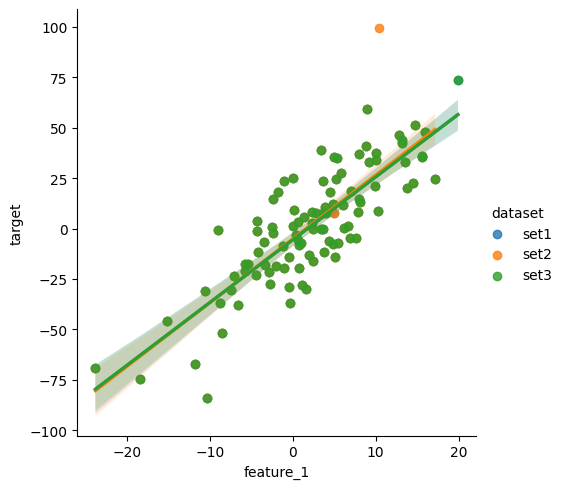

In [25]:
sns.lmplot(data = pd.concat([data_happiness.assign(dataset = 'set1'),
                                 data_happiness_outlier.assign(dataset = 'set2'),data_happiness_missing.assign(dataset = 'set3')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [26]:
data_happiness_missing.isna().sum()

feature_1     1
feature_2     0
feature_3    25
feature_4     0
feature_5    15
feature_6     0
target        0
dtype: int64

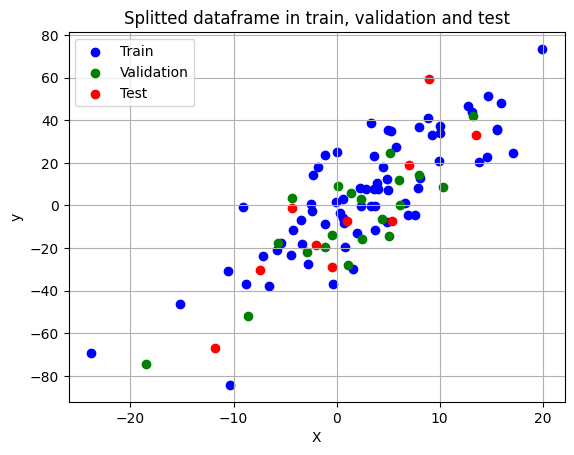

In [27]:
X_train, x_val, X_test, y_train, y_val, y_test = split(data_happiness, 0.7, 0.2, 0.1)

plt.scatter(X_train, y_train, c='b')
plt.scatter(x_val, y_val, c='g')
plt.scatter(X_test, y_test, c='r')
plt.title('Splitted dataframe in train, validation and test')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Train','Validation','Test'])
plt.grid()

In [28]:
x_h1 = data_happiness.target.values
y_h1 = data_happiness.feature_1.values

x_h1 = x_h1.reshape((100,1))
y_h1 = y_h1.reshape((100,1))

lr.fit(x_h1,y_h1)
lr.score(x_h1,y_h1)

0.6930335774077743

In [29]:
data_happiness_missing = df.fillna(0.0)
x_h2 = data_happiness_missing.target.values
y_h2 = data_happiness_missing.feature_1.values

x_h2 = x_h2.reshape((1000,1))
y_h2 = y_h2.reshape((1000,1))

lr.fit(x_h2,y_h2)
lr.score(x_h2,y_h2)

0.9855792900364626

In [30]:
x_h3 = data_happiness_outlier.target.values
y_h3 = data_happiness_outlier.feature_1.values

x_h3 = x_h3.reshape((100,1))
y_h3 = y_h3.reshape((100,1))

lr.fit(x_h3,y_h3)
lr.score(x_h3,y_h3)

0.651996427923456

# Ejercicio 6

Por último, manteniendo un dataset limpio como el que generamos previo al ejercio 1, utilizando `make_regression` de `scikit-learn`. Analizar que pasa si comenzamos a modificar el parametro `noise`

In [31]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 20,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [32]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-36.084949
1,1.031845,-10.272417
2,-0.487606,-27.694060
3,0.186454,-11.103187
4,0.725767,14.055202


<Axes: ylabel='Count'>

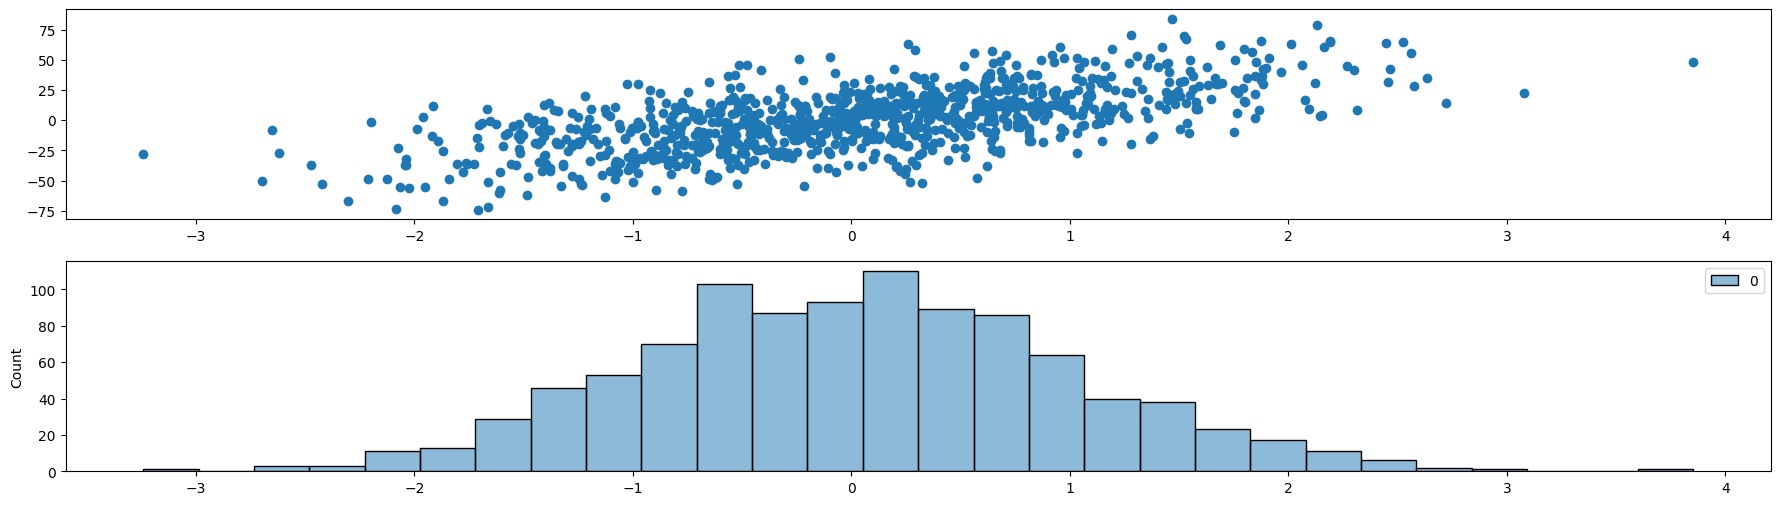

In [33]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1])